<a id="lb"></a>

<div style="background: linear-gradient(to right, #1b5e20, #2e7d32, #388e3c, #43a047, #4caf50); font-family: 'Times New Roman', serif; font-size: 28px; font-weight: bold; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">
    Topic extraction using BERT
</div>

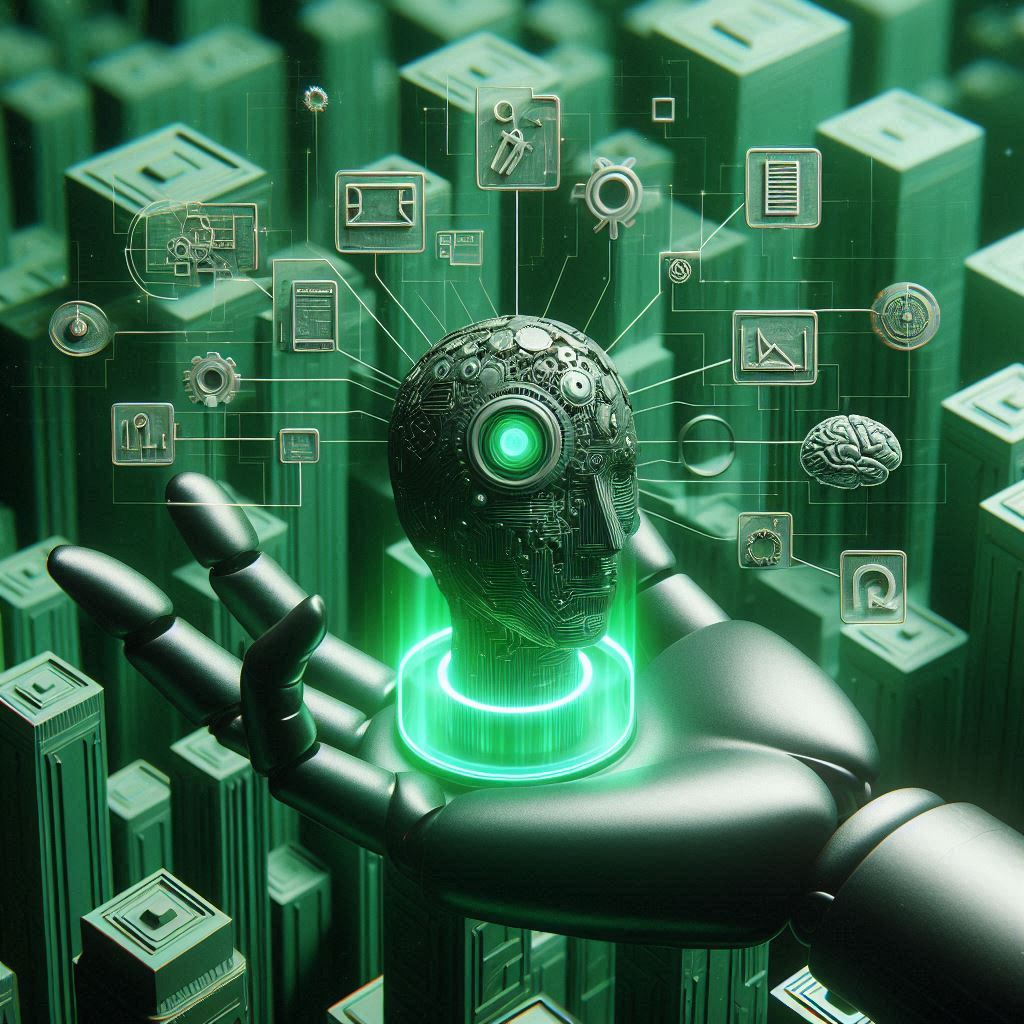
AI Generated XAI

<a id="lb"></a>

# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>Introduction</b></div>

Sentiment analysis is a crucial natural language processing (NLP) task that involves determining whether a piece of text expresses a positive, negative, or neutral sentiment. This project leverages BERT-based transformers to perform topic analysis on custormers comments about products.

<a id="lb"></a>
# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>Dataset Acquisition and Preprocessing</b></div>

For this project, we'll use the the comments about topics 548 and 558.

Note: Ensure you have downloaded the dataset and placed it in the working directory.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf

import keras
import keras_nlp

import torch

from tqdm import tqdm
from gensim.models import Word2Vec

# NLP Libraries
import re

In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/dataset2/dataset.csv')#/kaggle/input/dataset2 #/kaggle/input/dataset2/dataset.csv

# Display the first few rows
df.head()
# df.tail(800)

,Unnamed: 0,quote_id,topic_id,quote_text,label
0,0,1.522545e+10,548,"l'applicateur est un peu bizarre, pourquoi pas...",True
1,1,1.840193e+09,548,mais ça l'a repulpé un peu.,False
2,2,4.603383e+09,548,Points forts Odeur Facilité d'utilisatio...,False
3,3,9.409317e+09,548,Dior a juste changé le packaging ces dernières...,False
4,4,9.063266e+09,548,mais cela demande un peu plus de temps que de ...,False


<a id="lb"></a>
# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>Exploratory Data Analysis (EDA)</b></div>

Let's explore the dataset to understand its structure and distribution.

In [3]:
# data labelisation

labeled_df = df

def labelisation(row):
    if row.topic_id == 548 and row.label == True:
        return 1
    elif row.topic_id == 558 and row.label == True:
        return 2
    else:
        return 0
        
labeled_df['label'] = labeled_df.apply(labelisation, axis = 1)

Dataset contains 12589 rows and 5 columns.

Missing values in each column:
Unnamed: 0    0
quote_id      0
topic_id      0
quote_text    0
label         0
dtype: int64


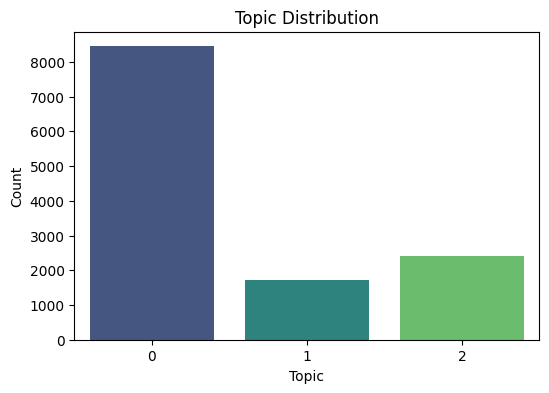

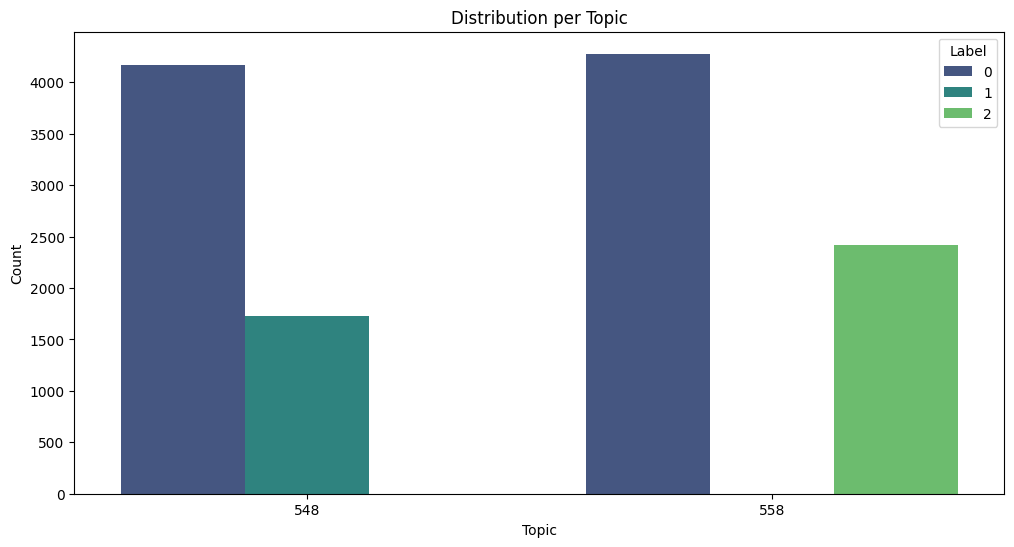

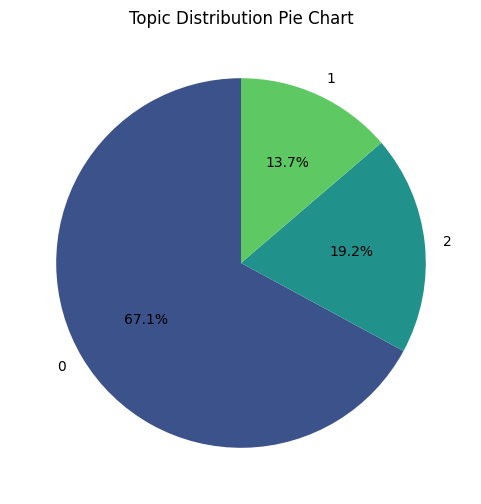

In [4]:
# Check the shape of the dataset
print(f"Dataset contains {labeled_df.shape[0]} rows and {labeled_df.shape[1]} columns.")

# Check for missing values
print("\nMissing values in each column:")
print(labeled_df.isnull().sum())

# Distribution of sentiments
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=labeled_df, palette='viridis')
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()

# Distribution of sentiments per airline
plt.figure(figsize=(12,6))
sns.countplot(x='topic_id', hue='label', data=labeled_df, palette='viridis')
plt.title('Distribution per Topic')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.legend(title='Label')
plt.show()

# Pie chart for sentiment distribution
plt.figure(figsize=(6,6))
labeled_df['label'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('viridis', 3), startangle=90)
plt.title('Topic Distribution Pie Chart')
plt.ylabel('')  # To remove the y-label
plt.show()

<a id="lb"></a>
# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>Data Preprocessing</b></div>

Preprocessing is crucial for improving the performance of NLP models. We'll clean the text data by removing URLs, mentions, special characters, stopwords, and perform lemmatization.

Note: When using BERT or other transformer-based models, minimal preprocessing is often preferred since these models are designed to handle raw text effectively. However, if you still choose to preprocess, ensure it doesn't remove essential information.

In [5]:
def preprocess_text(text):
    # Check if text is a string
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#','', text)
    
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Apply preprocessing
labeled_df['clean_text'] = labeled_df['quote_text'].apply(preprocess_text)

# Display cleaned text
labeled_df[['quote_text', 'clean_text']].head()

,quote_text,clean_text
0,"l'applicateur est un peu bizarre, pourquoi pas...",l applicateur est un peu bizarre pourquoi pas ...
1,mais ça l'a repulpé un peu.,mais ça a repulpé un peu
2,Points forts Odeur Facilité d'utilisatio...,points forts odeur facilité utilisation points...
3,Dior a juste changé le packaging ces dernières...,dior juste changé le packaging ces dernières a...
4,mais cela demande un peu plus de temps que de ...,mais cela demande un peu plus de temps que de ...


<a id="lb"></a>
# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>Feature Extraction</b></div>

We'll convert the text data into numerical features using Word2Vec Vectorization.

In [6]:

# Define features and labels
X = labeled_df['clean_text']
y = labeled_df['label']
#y = df['label'].map(lambda x: 0 if x==False else 1)  # Encoding partition

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
text_train = []

for i in tqdm(X_train):
    temp = i.split()
    text_train.append(temp)

100%|██████████| 10071/10071 [00:00<00:00, 264985.67it/s]


In [8]:
"""model = Word2Vec(window = 15, sg = 1, hs = 0,
                 negative = 10, 
                 alpha=0.03, min_alpha=0.0007,
                 seed = 121)

model.build_vocab(text_train, progress_per=200)

model.train(text_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)"""

'model = Word2Vec(window = 15, sg = 1, hs = 0,\n                 negative = 10, \n                 alpha=0.03, min_alpha=0.0007,\n                 seed = 121)\n\nmodel.build_vocab(text_train, progress_per=200)\n\nmodel.train(text_train, total_examples = model.corpus_count, \n            epochs=10, report_delay=1)'

In [9]:
"""w2v_model = model.wv[model.wv.index_to_key]

w2v_model.shape"""

'w2v_model = model.wv[model.wv.index_to_key]\n\nw2v_model.shape'

In [10]:
"""!pip install umap-learn -q"""

'!pip install umap-learn -q'

In [11]:
"""import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(w2v_model)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral');"""

"import umap.umap_ as umap\nimport warnings\nwarnings.filterwarnings('ignore')\n\ncluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,\n                              n_components=2, random_state=42).fit_transform(w2v_model)\n\nplt.figure(figsize=(10,9))\nplt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral');"

<a id="lb"></a>
# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>Model Training with BERT</b></div>

We'll utilize Hugging Face's transformers library to fine-tune a pre-trained BERT model for topic classification. BERT (Bidirectional Encoder Representations from Transformers) has achieved state-of-the-art results in various NLP tasks due to its deep bidirectional understanding of language.

<a id="lb"></a>
# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>1. Encoding Labels</b></div>

First, we'll encode the sentiment labels into numerical format.

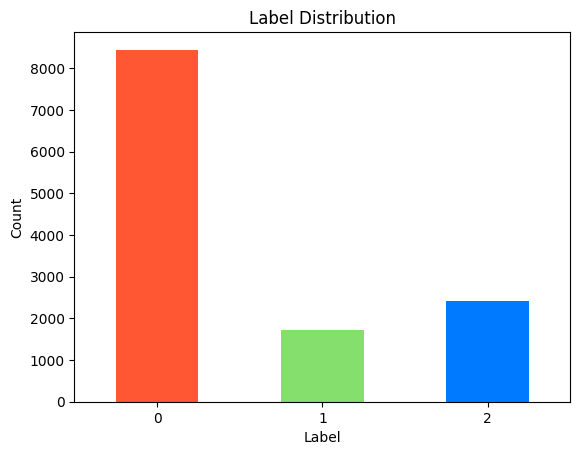

In [12]:
# Encode sentiments
#label_mapping = {False: 0, True: 1}
#df['label'] = df['label'].map(label_mapping)

# Display label distribution with custom colors
colors = ['#FF5733', '#85df6d', '#007BFF']  # Example colors: red, light green, and blue

labeled_df['label'].value_counts().sort_index().plot(kind='bar', color=colors)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=[0, 1, 2], rotation=0)
plt.show()

<a id="lb"></a>
# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>2. Splitting the Dataset</b></div>

We'll split the dataset into training and testing sets, ensuring a stratified split to maintain the distribution of classes.

In [14]:
# Define features and labels
X = labeled_df['clean_text']
y = labeled_df['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_test, X_test_true, y_test, y_test_true = train_test_split(
    X_test, y_test, test_size=0.2, random_state=42, stratify=y_test
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 10071
Testing set size: 2014


<a id="lb"></a>
# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>3. Tokenization</b></div>

BERT requires inputs to be tokenized in a specific way. We'll use the BertTokenizer for this purpose.

In [15]:
# Initialize the tokenizer
tokenizer = keras_nlp.models.BertTokenizer.from_preset("bert_small_en_uncased")

In [16]:
# Preprocessing: preprocessor transforms raw text data into the format required by the BERT model, 
# including tokenization, adding special tokens, and handling sequence length.
preprocessor = keras_nlp.models.BertPreprocessor(
    tokenizer, sequence_length=80, truncate="round_robin"
)

<a id="lb"></a>
# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>4. Creating Dataset Objects with Tensorflow / Keras</b></div>

We'll create a custom dataset class to feed data into the BERT model.

In [17]:
df_train = X_train
df_test = X_test
df_test_true = X_test_true

train_labels = y_train
test_labels = y_test
test_true_labels = y_test_true


train_text = tf.ragged.constant(df_train.values)
test_text = tf.ragged.constant(df_test.values)
test_true_text = tf.ragged.constant(df_test_true.values)

In [18]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_text, train_labels.values))
test_ds = tf.data.Dataset.from_tensor_slices((test_text, test_labels.values))
test_true_ds = tf.data.Dataset.from_tensor_slices((test_true_text, test_true_labels.values))

train_ds = train_ds.shuffle(batch_size).batch(batch_size)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE).batch(batch_size)
test_true_ds = test_true_ds.prefetch(buffer_size=tf.data.AUTOTUNE).batch(batch_size)

<a id="lb"></a>

# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>5. Fine-Tuning BERT</b></div>

We'll fine-tune the pre-trained BERT model on our topic analysis task.

In [19]:
num_labels = 3
model = keras_nlp.models.BertClassifier.from_preset(
    "bert_small_en_uncased", preprocessor=preprocessor, num_classes=num_labels
)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, name="Adam",)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy'],
    jit_compile=True
)

history = model.fit(train_ds, validation_data=test_ds, epochs=5, verbose=1)


Epoch 1/5


I0000 00:00:1734337762.745317     351 service.cc:145] XLA service 0x795858010e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734337762.745387     351 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/315 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.2500 - loss: 1.1183   

I0000 00:00:1734337786.369287     351 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/315 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6372 - loss: 0.8828

<a id="lb"></a>

# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>6. Training the Model</b></div>

In [ ]:
# Train the model
# history = model.fit(train_ds, validation_data=test_ds, epochs=5, verbose=1)


<a id="lb"></a>

# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>7. Evaluating the Model</b></div>

In [ ]:
# Evaluate the model

# Get training and validation data
data = history.history

# Create a new DataFrame
df = pd.DataFrame(data)
df['Epoch'] = df.index + 1

# Melt the DataFrame to make it suitable for seaborn
df_melted = df.melt(id_vars=['Epoch'], value_vars=['accuracy', 'loss', 'val_accuracy', 'val_loss'],
                    var_name='Metric', value_name='Value')

# Set the canvas size
plt.figure(figsize=(10, 6))

# Plot with seaborn
sns.lineplot(data=df_melted, x='Epoch', y='Value', hue='Metric', marker='o')

# Customize labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.title('Training and Validation Metrics Over Epochs')
plt.legend(title='Metrics', loc='best')

# Display the plot
plt.show()

<a id="lb"></a>
# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>Model Evaluation</b></div>

After training, we'll evaluate the model's performance on the test set using various metrics

In [ ]:
X_test_true.values

In [ ]:
# Evaluate with raw data
val_text = X_test_true.values
val_labels = y_test_true.values

raw_loss, raw_acc = model.evaluate(val_text, val_labels, verbose=1)

print(f"Accuaracy: {raw_acc}, Loss: {raw_loss}")

In [ ]:
X_val = X_test_true.values
y_preds = model.predict(X_val)
y_true = y_test_true.values

y_predicted = []

for y_pred in y_preds:
    y_predicted.append(np.argmax(y_pred))

from sklearn.metrics import f1_score, multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report

print(f"f1-micro: {f1_score(y_true, y_predicted, average='macro')}")
print(f"f1-weighted: {f1_score(y_true, y_predicted, average='weighted')}")
print(f"f1-score: {f1_score(y_true, y_predicted, average=None)}")

cm = multilabel_confusion_matrix(y_true, y_predicted)
print(classification_report(y_true, y_predicted))

In [ ]:

labels = ['None', 'Topic 1', 'Topic 2']

for i in range(len(cm)):
    
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(include_values=True, cmap="Greens", ax=None, xticks_rotation="vertical")
    plt.title("Confusion Matrix - Class: " + labels[i])

    plt.show()

<a id="lb"></a>

# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>Explainable AI with LIME</b></div>

Explainable AI helps in understanding how the model makes its predictions. We'll use LIME (Local Interpretable Model-agnostic Explanations) to interpret the predictions of our BERT-based model by highlighting the most influential words in the input text.
<a id="lb"></a>

# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>1. Installing and Importing LIME</b></div>

In [ ]:
# Explainable AI Libraries
#!pip install lime
#from lime.lime_text import LimeTextExplainer

<a id="lb"></a>

# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>2. Preparing the Explainer</b></div>

We'll set up a LIME explainer for text data.

In [ ]:
from lime.lime_text import LimeTextExplainer

# Define class names
class_names = ['None', 'Topic 1', 'Topic 2']

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=class_names)

<a id="lb"></a>

# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>3. Defining a Prediction Function</b></div>

LIME requires a prediction function that takes raw text and returns probability distributions over classes.

In [ ]:
def predict_proba(texts):
    # Tokenize the texts
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    # Move tensors to the same device as the model
    encodings = {key: val.to(model.device) for key, val in encodings.items()}
    
    # Get logits from the model
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs

<a id="lb"></a>

# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>4. Explaining a Single Predictions</b></div>

Let's choose a sample comment and explain its prediction.

In [ ]:
# Select a sample from the test set
sample_idx = 42  # You can change this index to explore different samples
sample_text = X_test.iloc[sample_idx]
actual_sentiment = y_test.iloc[sample_idx]
predicted_sentiment = preds[sample_idx]

print(f"Original Tweet: {df.iloc[X_test.index[sample_idx]]['text']}")
print(f"Cleaned Tweet: {sample_text}")
print(f"Actual Sentiment: {class_names[actual_sentiment]}")
print(f"Predicted Sentiment: {class_names[predicted_sentiment]}")

# Generate explanation
exp = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10,
    labels=[predicted_sentiment]
)

# Display the explanation
exp.show_in_notebook(text=True)

<a id="lb"></a>

# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>5. Explaining Multiple Predictions</b></div>

We can also visualize explanations for multiple samples to gain broader insights.

In [ ]:
# Function to display explanations for multiple samples
def display_lime_explanations(texts, labels, preds, num_samples=3):
    for i in range(num_samples):
        idx = np.random.randint(0, len(texts))
        text = texts.iloc[idx]
        actual = labels.iloc[idx]
        pred = preds[idx]
        print(f"\nSample {i+1}")
        print(f"Original Tweet: {df.iloc[X_test.index[idx]]['text']}")
        print(f"Cleaned Tweet: {text}")
        print(f"Actual Sentiment: {class_names[actual]}")
        print(f"Predicted Sentiment: {class_names[pred]}")
        exp = explainer.explain_instance(
            text,
            predict_proba,
            num_features=10,
            labels=[pred]
        )
        exp.show_in_notebook(text=True)

# Display explanations for 3 random samples
display_lime_explanations(X_test, y_test, preds, num_samples=3)

<a id="lb"></a>

# <div style="background-color: #85df6d; font-family: 'Times New Roman', serif; font-size: 36px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);"><b>Conclusion</b></div>

In this notebook, we leveraged a BERT-based transformer model to perform topic analysis on custormer comments. BERT's deep bidirectional understanding enabled the model to achieve high accuracy in classifying topic as None, 548, or 558. Additionally, by integrating LIME, we provided explanations for individual predictions, highlighting the most influential words or phrases that drove the model's decisions. This combination of advanced modeling and explainability ensures both high performance and transparency, which are crucial for organizations to understand public perception and make informed decisions based on sentiment analysis.